In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds
from readout import load_results
import spatial

import conf.isi5_500 as cfg
from demonstrator import demonstrator

import styling

In [2]:
K = 1.4
STD = 1
net, ipair, istim, isi, templ = [demonstrator[k] for k in ('net', 'ipair', 'istim', 'isi', 'templ')]
pair, stim, Bstim = cfg.pairings[ipair], cfg.pairings[ipair][istim], cfg.pairings[ipair][1-istim]

In [3]:
netf = dd.io.load(cfg.netfile.format(net=net))
X, Y = netf['X']/cfg.params['r_dish'].item(), netf['Y']/cfg.params['r_dish'].item()
W = netf['W']
Wb = W>0
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)
Xstim = Xstim / cfg.params['r_dish']
Ystim = Ystim / cfg.params['r_dish']

In [4]:
TA = 0
res0 = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ))

episodes0 = {cond: res0['pairs'][ipair][cond][stim] for cond in conds}
sequences0 = {cond: res0['sequences'][episode] for cond, episode in episodes0.items()}
trials0 = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences0.items()}
trials0.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences0.items()})
trials0.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences0.items()})

bspikes0 = {}
for cond in conds:
    bspikes0[cond] = np.zeros((cfg.params['N'], len(sequences0[cond]), res0['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res0['raw_spikes'][episodes0[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        bspikes0[cond][i, itrial, t] = True
    assert np.all(bspikes0[cond].sum(2) == res0['raw_spikes'][episodes0[cond]]['pulsed_nspikes'].T)

In [5]:
XA0 = np.mean([bspikes0[cond][:, trials0[cond]].sum(2).mean(1) for cond in ('dev', 'msc')], 0)
xrA0 = {cond: 1-res0['raw_dynamics']['neuron_xr'][:, episodes0[cond], trials0[cond], 0].mean(1) for cond in ('dev', 'msc')}
DA0 = {cond: np.einsum('eo,e->o', Wb, XA0*xr) * K for cond, xr in xrA0.items()}
DA0['diff'] = DA0['dev'] - DA0['msc']

XB0 = np.mean([bspikes0[cond][:, trials0[f'{cond}-B']].sum(2).mean(1) for cond in ('dev', 'msc')], 0)
xrB0 = {cond: 1-res0['raw_dynamics']['neuron_xr'][:, episodes0[cond], trials0[f'{cond}-B'], 0].mean(1) for cond in ('dev', 'msc')}
DB0 = {cond: np.einsum('eo,e->o', Wb, XB0*xr) * K for cond, xr in xrB0.items()}
DB0['diff'] = DB0['dev'] - DB0['msc']

In [6]:
RA0 = {cond: spikes[:, trials0[cond]].sum(2).mean(1) for cond, spikes in bspikes0.items()}
RA0['diff'] = RA0['dev'] - RA0['msc']
RB0 = {cond: spikes[:, trials0[f'{cond}-B']].sum(2).mean(1) for cond, spikes in bspikes0.items()}
RB0['diff'] = RB0['dev'] - RB0['msc']

In [7]:
TA = 1
res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ))

episodes = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
sequences = {cond: res['sequences'][episode] for cond, episode in episodes.items()}
trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

bspikes = {}
for cond in conds:
    bspikes[cond] = np.zeros((cfg.params['N'], len(sequences[cond]), res['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episodes[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        bspikes[cond][i, itrial, t] = True
    assert np.all(bspikes[cond].sum(2) == res['raw_spikes'][episodes[cond]]['pulsed_nspikes'].T)

In [8]:
XA = np.mean([bspikes[cond][:, trials[cond]].sum(2).mean(1) for cond in ('dev', 'msc', 'std')], 0)
xrA = {cond: 1-res['raw_dynamics']['neuron_xr'][:, episodes[cond], trials[cond], 0].mean(1) for cond in ('dev', 'msc')}
DA = {cond: np.einsum('eo,e->o', Wb, XA*xr) * K for cond, xr in xrA.items()}
DA['diff'] = DA['dev'] - DA['msc']

XB = np.mean([bspikes[cond][:, trials[f'{cond}-B']].sum(2).mean(1) for cond in ('dev', 'msc', 'std')], 0)
xrB = {cond: 1-res['raw_dynamics']['neuron_xr'][:, episodes[cond], trials[f'{cond}-B'], 0].mean(1) for cond in ('dev', 'msc')}
DB = {cond: np.einsum('eo,e->o', Wb, XB*xr) * K for cond, xr in xrB.items()}
DB['diff'] = DB['dev'] - DB['msc']

In [9]:
RA = {cond: spikes[:, trials[cond]].sum(2).mean(1) for cond, spikes in bspikes.items()}
RA['diff'] = RA['dev'] - RA['msc']
RB = {cond: spikes[:, trials[f'{cond}-B']].sum(2).mean(1) for cond, spikes in bspikes.items()}
RB['diff'] = RB['dev'] - RB['msc']

A, sample: $\rho$ = -0.496, p = 2e-63


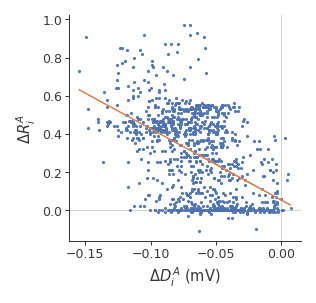

In [10]:
def panel_correlation(ax, D, R, thestim, ms=1):
    ax.plot(D['diff'], R['diff'], '.', ms=ms)

    reg = stats.linregress(D['diff'], R['diff'], alternative='less')
    print(f'{thestim}, sample: $\\rho$ = {reg.rvalue:.3g}, p = {reg.pvalue:.3g}')
    plt.plot(D['diff'], D['diff']*reg.slope + reg.intercept)

    plt.xlabel(f'$\\Delta {pu.D(stim=thestim, index="i")}$ (mV)')
    plt.ylabel(f'$\\Delta {pu.R(stim=thestim, index="i")}$')
    ax.axvline(0, color='lightgrey', zorder=0)
    ax.axhline(0, color='lightgrey', zorder=0)
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_correlation(ax, DA, RA, 'A')

In [11]:
def scatter_values(ax, **kwargs):
    m = ax.scatter(X, Y, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_aspect('equal')
    sns.despine(ax=ax, left=True, bottom=True)
    return m

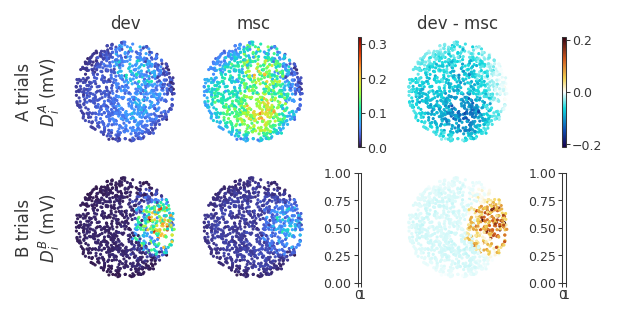

In [12]:
def panel_D(axs_raw, axs_contrast, cax_raw, cax_contrast, DA, DB, ms=1):
    vmax = np.abs([DA['dev'], DA['msc'], DB['dev'], DB['msc']]).max()
    m = scatter_values(axs_raw[0, 0], c=DA['dev'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    m = scatter_values(axs_raw[0, 1], c=DA['msc'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    m = scatter_values(axs_raw[1, 0], c=DB['dev'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    m = scatter_values(axs_raw[1, 1], c=DB['msc'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    plt.colorbar(m, cax=cax_raw)

    vmax = np.abs([DA['diff'], DB['diff']]).max()
    m = scatter_values(axs_contrast[0], c=DA['diff'], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    m = scatter_values(axs_contrast[1], c=DB['diff'], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    plt.colorbar(m, cax=cax_contrast)

    for ax, cond in zip([*axs_raw[0], axs_contrast[0]], ('dev', 'msc', 'dev - msc')):
        ax.set_title(cond)
    for ax, AB in zip(axs_raw[:, 0], 'AB'):
        ax.set_ylabel(f'{AB} trials\n${pu.D(stim=AB, index="i")}$ (mV)', fontsize=plt.rcParams['axes.titlesize'])
fig, axs = plt.subplots(2, 5, figsize=(4, 2), constrained_layout=True, width_ratios=pu.fill_ratios(-1,-1,1,-1,1), dpi=150)
panel_D(axs[:, :2], axs[:, 3], axs[0,2], axs[0,4], DA, DB)

In [13]:
Ddata = dd.io.load('suppression.TA1.h5', '/D')
Rdata = dd.io.load('suppression.TA1.h5', '/R')
Ddata_TA0 = dd.io.load('suppression.TA0.h5', '/D')
Rdata_TA0 = dd.io.load('suppression.TA0.h5', '/R')

In [14]:
statistics = dd.io.load('stats.h5')

A rho < 0: T = 724, p = 1.37e-14, median = -0.282
dD^A < 0: T = 757, p = 2.66e-14, median = -0.008


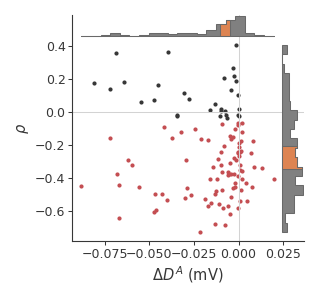

In [15]:
def panel_correlation_stats(ax, Ddata, Rdata, thestim, ms=2):
    R = {cond: np.asarray([R[thestim][cond] for R in Rdata]) for cond in ('dev', 'msc')}
    D = {cond: np.asarray([D[thestim][cond] for D in Ddata]) for cond in ('dev', 'msc')}
    dR = R['dev'] - R['msc']
    dD = D['dev'] - D['msc']
    r = []
    for k in range(dR.shape[0]):
        regression = stats.linregress(dD[k], dR[k], alternative='less')
        plt.plot(np.median(dD[k]), regression.rvalue, '.', ms=ms, c='r' if regression.pvalue < .05 else styling.offblack)
        r.append(regression.rvalue)
    s = np.median(dD, 1)
    ax.set_xlabel(f'$\\Delta {pu.D(stim=thestim)}$ (mV)')
    ax.set_ylabel('$\\rho$')
    pu.inset_hist(ax, r, False)
    pu.inset_hist(ax, s, True)
    ax.axhline(0, color='lightgrey')
    ax.axvline(0, color='lightgrey')
    sns.despine(ax=ax)
    
    test = stats.wilcoxon(r, alternative='less')
    print(f'{thestim} rho < 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(r):.3f}')
    test = stats.wilcoxon(s, alternative='less' if thestim=='A' else 'greater')
    print(f'dD^{thestim} {"<" if thestim=="A" else ">"} 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(s):.3f}')

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
panel_correlation_stats(ax, Ddata[1], Rdata[1], 'A')

dD^B (early) ~ dXB: $\rho$ = -0.581, p = 1.81e-12


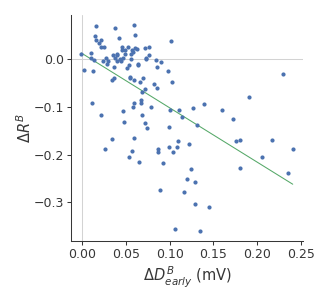

In [16]:
def panel_dDBearly_drives_dXB(ax, TA, ms=2):
    dD, dX = statistics['dD_B_early'][TA], np.median(statistics['adaptation'][1][TA], 1)
    ax.plot(dD, dX, '.', ms=ms, zorder=2)
    reg = stats.linregress(dD, dX, alternative='less')
    lohi = np.asarray([dD.min(), dD.max()])
    ax.plot(lohi, lohi*reg.slope + reg.intercept, 'C2', zorder=1)

    ax.axvline(0, color='lightgrey', zorder=0)
    ax.axhline(0, color='lightgrey', zorder=0)
    ax.set_xlabel(f'$\\Delta {pu.D(stim="B", index="early")}$ (mV)')
    ax.set_ylabel(f'$\\Delta {pu.R(stim="B")}$')
    sns.despine(ax=ax)

    print(f'dD^B (early) ~ dXB: $\\rho$ = {reg.rvalue:.3g}, p = {reg.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_dDBearly_drives_dXB(ax, 1)

dXnotA ~ dD_B, rho > 0: T = 7.26e+03, p = 1.01e-21, median = 0.430
early dD_B > 0: T = 7.26e+03, p = 1.01e-21
late dD_B < 0: T = 2.24e+03, p = 0.000133
all dD_B < 0: T = 2.64e+03, p = 0.00465


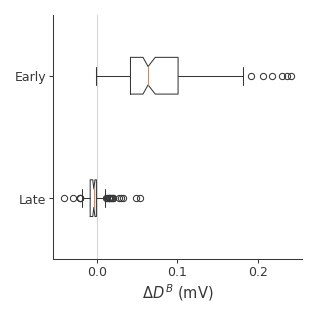

In [17]:
def panel_D_early_stats(ax, TA, vert=False):
    ax.boxplot(
        [statistics[f'dD_B_{key}'][TA] for key in ('early', 'late')], labels=['Early', 'Late'], widths=.3, zorder=1,
        vert=vert, notch=True, bootstrap=10000, positions=(1-vert,vert))
    if vert:
        ax.set_ylabel(f'$\\Delta {pu.D(stim="B")}$ (mV)')
        ax.axhline(0, color='lightgrey', zorder=0)
    else:
        ax.set_xlabel(f'$\\Delta {pu.D(stim="B")}$ (mV)')
        ax.axvline(0, color='lightgrey', zorder=0)
    sns.despine(ax=ax)

    r = []
    for dx, dth in zip(statistics['dXnotA'][1][TA], statistics['dD_B'][TA]):
        regression = stats.linregress(dx, dth, alternative='greater')
        r.append(regression.rvalue)
    test = stats.wilcoxon(r, alternative='greater')
    print(f'dXnotA ~ dD_B, rho > 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(r):.3f}')

    test = stats.wilcoxon(statistics['dD_B_early'][TA], alternative='greater')
    print(f'early dD_B > 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.wilcoxon(statistics['dD_B_late'][TA], alternative='less')
    print(f'late dD_B < 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(np.median(statistics['dD_B'][TA], 1), alternative='less')
    print(f'all dD_B < 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(2,2), dpi=150, layout='constrained')
panel_D_early_stats(ax, 1)

In [18]:
def draw_stim_loc(ax):
    for s, AB in zip((stim, Bstim), 'AB'):
        x, y = [c[res['stimuli'][s]] for c in (Xstim, Ystim)]
        r = .2
        o = 1/np.sqrt(x**2+y**2)
        lpoints = np.asarray([1+r, .1+o])
        ax.add_patch(plt.Circle((x, y), r, fc='lightgrey', ec='grey', zorder=0))
        ax.plot(lpoints*x, lpoints*y, 'grey', clip_on=False, zorder=0)
        ax.text(lpoints[-1]*x, lpoints[-1]*y, AB, ha='left' if x>=0 else 'right', va='bottom' if y>=0 else 'top')

With TA:
A, sample: $\rho$ = -0.496, p = 2e-63
A rho < 0: T = 724, p = 1.37e-14, median = -0.282
dD^A < 0: T = 757, p = 2.66e-14, median = -0.008
dXnotA ~ dD_B, rho > 0: T = 7.26e+03, p = 1.01e-21, median = 0.430
early dD_B > 0: T = 7.26e+03, p = 1.01e-21
late dD_B < 0: T = 2.24e+03, p = 0.000133
all dD_B < 0: T = 2.64e+03, p = 0.00465
dD^B (early) ~ dXB: $\rho$ = -0.581, p = 1.81e-12

Without TA:
A, sample: $\rho$ = 0.128, p = 1
A rho < 0: T = 3.99e+03, p = 0.828, median = -0.002
dD^A < 0: T = 4.08e+03, p = 0.882, median = 0.005
dXnotA ~ dD_B, rho > 0: T = 7.26e+03, p = 9.86e-22, median = 0.298
early dD_B > 0: T = 7.06e+03, p = 1.2e-19
late dD_B < 0: T = 6.36e+03, p = 1
all dD_B < 0: T = 6.45e+03, p = 1
dD^B (early) ~ dXB: $\rho$ = 0.423, p = 1


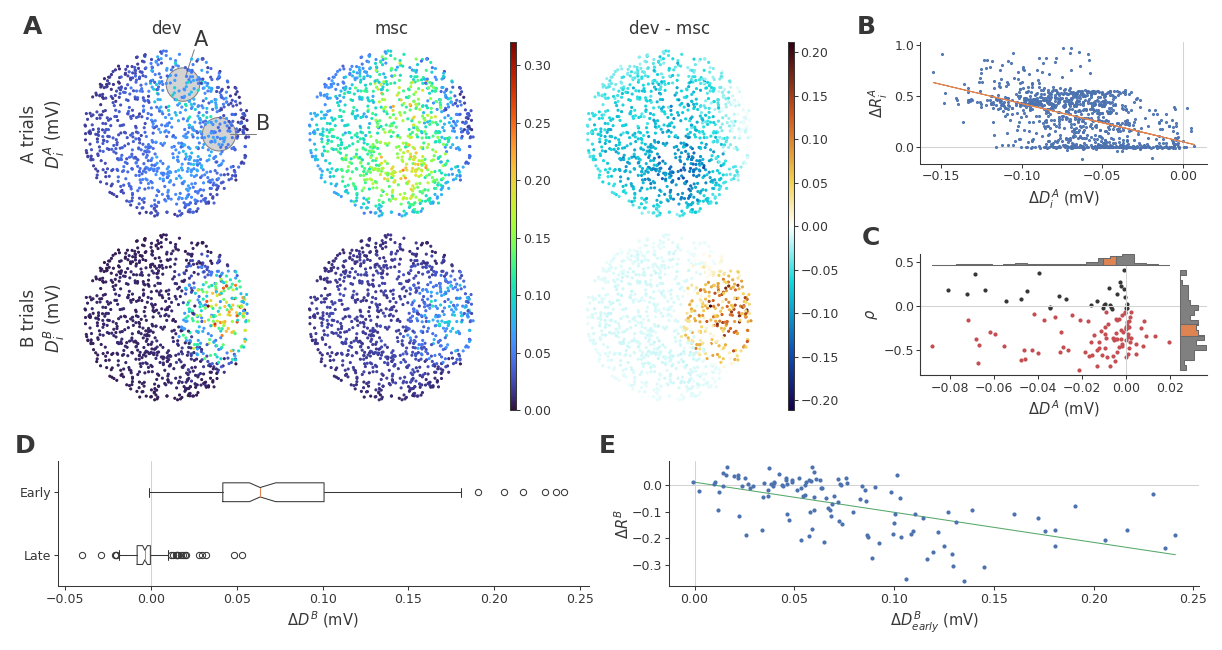

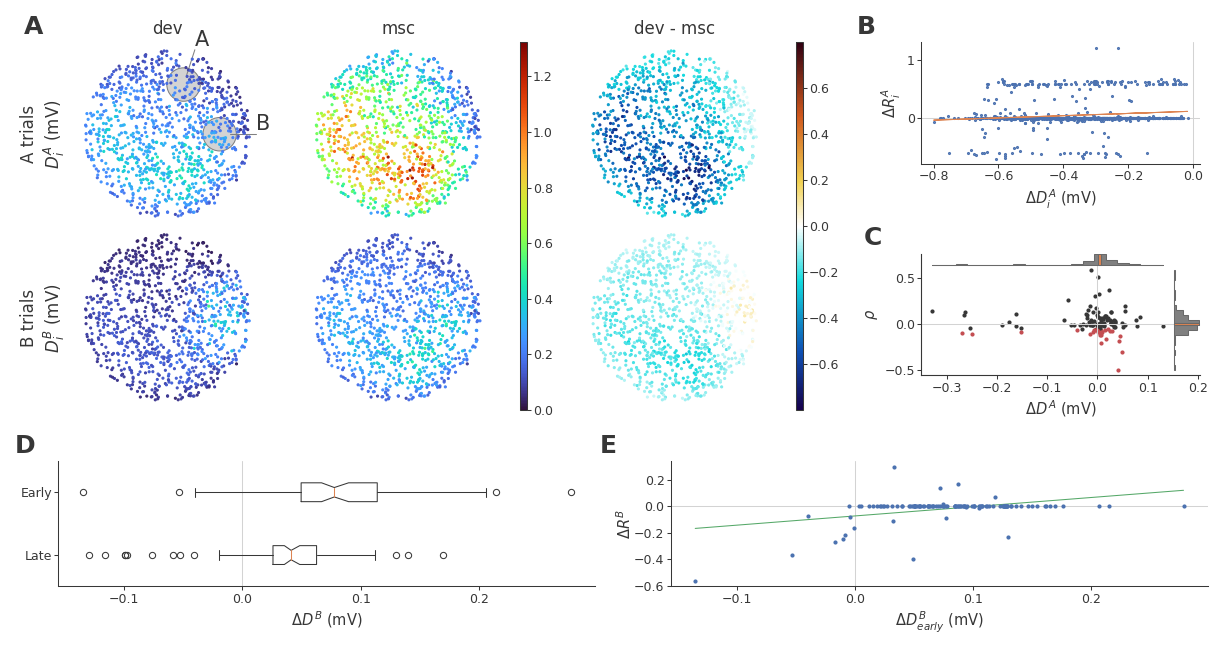

In [19]:
def make_fig8(DA, DB, Ddata, RA, RB, Rdata, TA):
    fig = plt.figure(figsize=pu.fullwidth(3.25), layout='compressed', dpi=150)
    gs_top = fig.add_gridspec(2, 2, width_ratios=(7,3), height_ratios=(2,1))

    subfig_left = fig.add_subfigure(gs_top[0, 0])
    wr = pu.fill_ratios(-1, -1, 1, -1, 1)
    gs_left = subfig_left.add_gridspec(2, 5, width_ratios=wr, hspace=0)
    cax_raw = subfig_left.add_subplot(gs_left[:, 2])
    cax_contrast = subfig_left.add_subplot(gs_left[:, -1])
    axs_raw = np.asarray([[subfig_left.add_subplot(gs_left[row, col]) for col in range(2)] for row in range(2)])
    axs_contrast = [subfig_left.add_subplot(gs_left[row, 3]) for row in range(2)]
    panel_D(axs_raw, axs_contrast, cax_raw, cax_contrast, DA, DB)
    draw_stim_loc(axs_raw[0,0])
    subfig_left.get_layout_engine().set(h_pad=0, hspace=0.05)
    pu.label_panel(axs_raw[0,0], 0, left=.8)

    subfig_right = fig.add_subfigure(gs_top[0, 1])
    gs_right = subfig_right.add_gridspec(2)
    ax = subfig_right.add_subplot(gs_right[0])
    panel_correlation(ax, DA, RA, 'A')
    pu.label_panel(ax, 1)

    ax = subfig_right.add_subplot(gs_right[1])
    panel_correlation_stats(ax, Ddata, Rdata, 'A')
    pu.label_panel(ax, 2)

    subfig_bottom = fig.add_subfigure(gs_top[1, :])
    gs_bottom = subfig_bottom.add_gridspec(1, 2)
    ax = subfig_bottom.add_subplot(gs_bottom[0])
    panel_D_early_stats(ax, TA)
    pu.label_panel(ax, 3, left=.9)

    ax = subfig_bottom.add_subplot(gs_bottom[1])
    panel_dDBearly_drives_dXB(ax, TA)
    pu.label_panel(ax, 4)

print('With TA:')
make_fig8(DA, DB, Ddata[1], RA, RB, Rdata[1], 1)
plt.savefig('paper-1/fig-synergy.pdf')

print('\nWithout TA:')
make_fig8(DA0, DB0, Ddata_TA0[1], RA0, RB0, Rdata_TA0[1], 0)
plt.savefig('paper-1/fig-synergy-noTA.pdf')

In [20]:
spikes = res['spikes'][ipair][stim]['dev']['nspikes'].mean(0)
stimid = res['stimuli'][stim]
r, p = [], []
for dtrial in range(1,4):
    shifted = np.roll(sequences['dev'], dtrial)
    shifted[:dtrial] = -1
    x = res['raw_dynamics']['neuron_xr'][:, episodes['dev'], shifted==stimid, 0].mean(1)
    correlation = stats.pearsonr(spikes[:cfg.params['N_exc']], x[:cfg.params['N_exc']])
    r.append(correlation[0])
    p.append(correlation[1])
    print(f'Lag {dtrial}: r = {r[-1]:.3g}, p = {p[-1]:.3g}')

Lag 1: r = -0.983, p = 0
Lag 2: r = -0.0642, p = 0.0696
Lag 3: r = -0.197, p = 2.07e-08


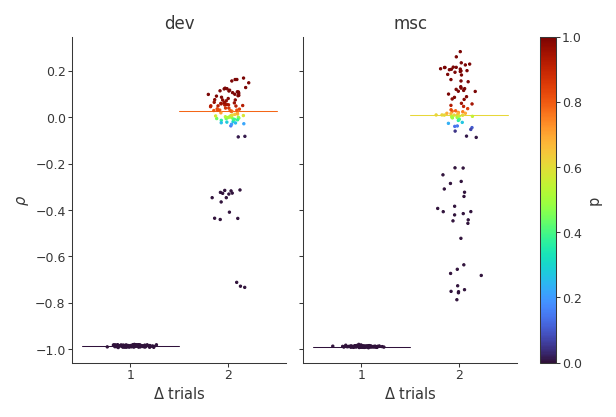

In [21]:
spikes = res['spikes'][ipair][stim]['msc']['nspikes'].T
stimid = res['stimuli'][stim]
r, p = [], []
fig, axs = plt.subplots(1,2, figsize=pu.halfwidth(2), dpi=150, layout='constrained', sharey=True)
for dtrial in range(1,3):
    for ax, cond in zip(axs, ('dev', 'msc')):
        ax.set_title(cond)
        shifted = np.roll(sequences[cond], dtrial)
        shifted[:dtrial] = -1
        x = res['raw_dynamics']['neuron_xr'][:, episodes[cond], shifted==stimid, 0]
        
        rho, prob = [], []
        for trial in range(x.shape[1]):
            corr = stats.pearsonr(
                res['spikes'][ipair][stim][cond]['nspikes'].T[:cfg.params['N_exc'], trial],
                x[:cfg.params['N_exc'], trial],
                alternative='less')
            rho.append(corr.statistic)
            prob.append(corr.pvalue)
        scatter = np.random.normal(dtrial, .1, len(rho))
        cmap = plt.colormaps.get_cmap('turbo')
        m = ax.scatter(scatter, rho, marker='.', s=5, c=np.asarray(prob), cmap=cmap, vmin=0, vmax=1, zorder=1)
        ax.plot([dtrial-.5, dtrial+.5], [np.median(rho)]*2, zorder=0, c=cmap(np.median(prob)))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.colorbar(m, ax=axs, label='p')
axs[0].set_ylabel('$\\rho$')
for ax in axs:
    ax.set_xlabel('$\\Delta$ trials')
    sns.despine(ax=ax)

plt.savefig('paper-1/sfig-STD-correlation-decay.pdf')